# Machine Learning and Pattern Classification - The haunted turtles
~Noah Pichler, Jacob Harrer, Martin Gegenbauer, Christopher Schicho
## Data Exploration

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
sns.set()

In [3]:
anot = pd.read_pickle("./data/task_2_annotations.pkl").reset_index()
anot.head()

,index,pianist_id,segment_id,annotator_id,arousal,valence,gems_wonder,gems_transcendence,gems_tenderness,gems_nostalgia,gems_peacefulness,gems_power,gems_joyful_activation,gems_tension,gems_sadness,gemmes_flow,gemmes_movement,gemmes_force,gemmes_interior,gemmes_wandering
0,0,1,0,91,1,-1,2,1,2,4,2.0,1,1,1,2,3,2,1,1.0,2
1,31,1,0,19,2,-1,3,3,3,4,4.0,1,2,3,3,3,2,2,3.0,3
2,62,1,0,189,2,0,2,1,2,1,4.0,2,2,1,1,3,2,1,1.0,4
3,93,1,0,126,2,2,4,5,2,3,5.0,2,4,1,3,5,1,2,2.0,5
4,124,1,0,26,4,2,3,5,2,3,3.0,1,3,4,1,4,1,2,3.0,1


In [4]:
feat = pd.read_pickle("./data/task_2_features.pkl")
feat.head()

,pianist_id,segment_id,snippet_id,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,...,mirtoolbox_novelty_std,mirtoolbox_novelty_pct_10,mirtoolbox_novelty_pct_50,mirtoolbox_novelty_pct_90,mirtoolbox_pulseclarity,mirtoolbox_roughness_mean,mirtoolbox_roughness_std,mirtoolbox_roughness_pct_10,mirtoolbox_roughness_pct_50,mirtoolbox_roughness_pct_90
0,1,0,0,0.192237,0.059404,2.040252,16079768.0,0.8,0.677256,0.095846,...,0.106446,0.00000,0.013819,0.082176,0.169743,0.011449,0.004161,0.006684,0.011048,0.017025
1,1,0,1,0.143425,0.064204,3.138845,35489248.0,2.6,0.514913,0.092372,...,0.193342,0.00000,0.027786,0.356029,0.355861,0.006205,0.003194,0.002583,0.005657,0.010610
2,1,0,2,0.146967,0.056205,2.019706,42130144.0,2.6,0.560116,0.115359,...,0.218179,0.00000,0.049050,0.375251,0.209162,0.007467,0.003986,0.002330,0.007206,0.012690
3,1,0,3,0.158810,0.059129,3.567908,40922732.0,1.4,0.596779,0.116061,...,0.118148,0.00002,0.017653,0.098657,0.232454,0.007335,0.004063,0.002609,0.006807,0.012971
4,1,0,4,0.168547,0.049648,2.329854,51921612.0,1.6,0.556160,0.143420,...,0.121018,0.00000,0.020525,0.157408,0.140930,0.007345,0.003917,0.002662,0.007016,0.012731


In [5]:
# quick overview of the annotations
anot.describe().loc[:,'arousal':'gemmes_wandering']

,arousal,valence,gems_wonder,gems_transcendence,gems_tenderness,gems_nostalgia,gems_peacefulness,gems_power,gems_joyful_activation,gems_tension,gems_sadness,gemmes_flow,gemmes_movement,gemmes_force,gemmes_interior,gemmes_wandering
count,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2637.000000,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2637.000000,2638.000000
mean,2.929492,0.020849,2.901440,2.673616,2.366187,2.723275,2.395525,2.313495,2.276725,2.596664,2.148218,2.968537,2.561031,2.434420,2.690178,2.496209
std,1.184031,1.099842,1.267184,1.235916,1.297041,1.371744,1.367916,1.232190,1.239287,1.412181,1.177312,1.329116,1.261079,1.264754,1.258940,1.279556
min,1.000000,-2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,-1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000
50%,3.000000,0.000000,3.000000,3.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,1.000000,4.000000,4.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000
max,5.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


<AxesSubplot:>

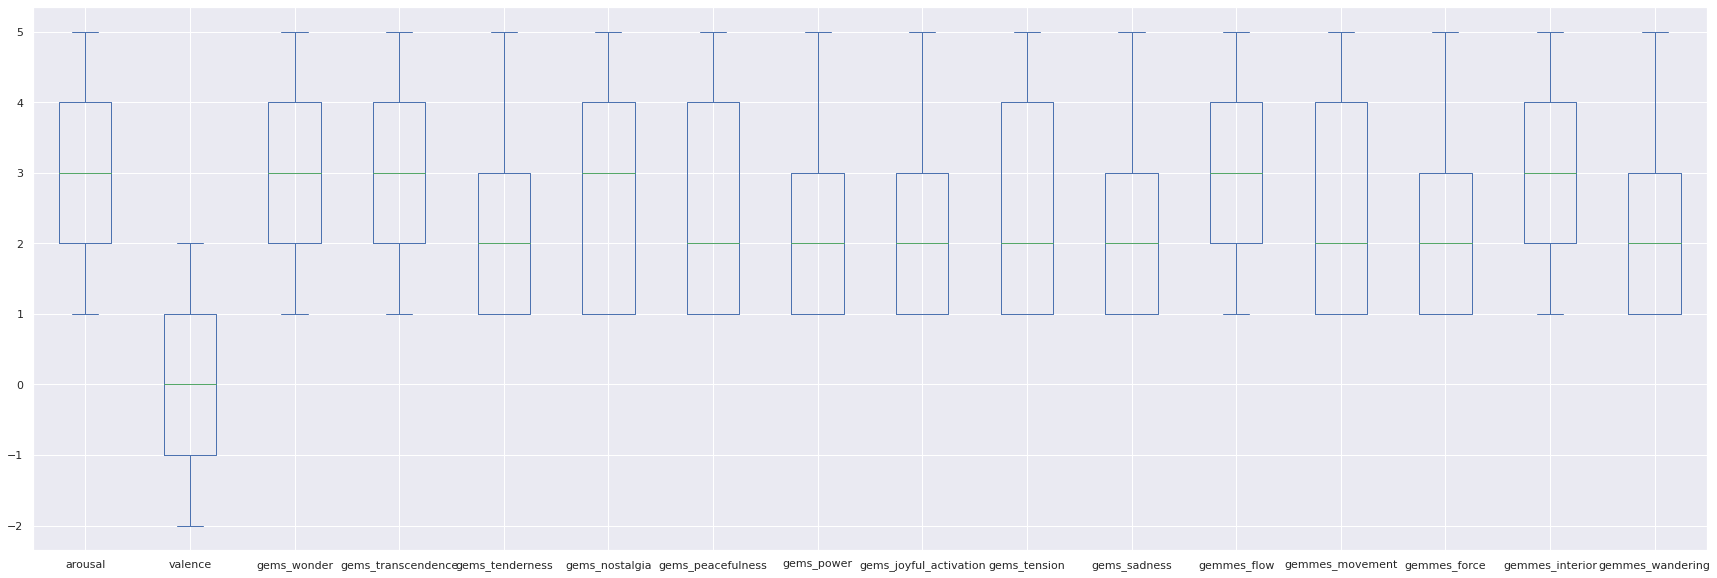

In [6]:
anot.loc[:,'arousal':'gemmes_wandering'].plot.box(figsize=(30,10))

In [7]:
# Calculates the mean, median, standard deviation for each segment and pianist
mean_seg = []
median_seg = []
std_seg = []
for pia_id in range(1, anot["pianist_id"][len(anot)-1] + 1):
    pianist = anot[anot["pianist_id"] == pia_id]
    for seg_id in range(1, anot["segment_id"][len(anot)-1] + 1):
        mask = pianist["segment_id"] == seg_id
        mean_seg.append(pianist[mask].mean(axis=0))
        median_seg.append(pianist[mask].median(axis=0))
        std_seg.append(pianist[mask].std(axis=0))

In [8]:
def plot_outliers(dataframe, outliers, multiplier=1.25, use_median=True, start_feature='arousal', 
                  end_feature='gemmes_wandering', y_axis_start=None, y_axis_end=5, fig_size=(30, 12)):
    """
    :dataframe: dataframe for which the median/mad or mean/std are calculated
    :outliers: dataframe of the outliers
    :multiplier: multiplier for the used median absolute deviation or standard deviation (ajust for extremer outliers)
    :use_median: boolean flag if the median/mad or the mean/std should be used
    :start_feature: feature from which the plot should start
    :end_feature: feature where the plot should end
    :y_axis_start: value which controlls the y_axis start scale (for scale true plotting)
    :y_axis_end: value which controlls the y_axis end scale (for scale true plotting)
    :fig_size: controlls the figure size of the plot
    
    :returns: a plot of the outliers in comparison with the median/mad-tolerance or mean/standard deviation
    """
    features = list(dataframe.columns)
    pd.DataFrame(outliers.loc[:, start_feature:end_feature]).T.plot.bar(figsize=fig_size)
    
    if use_median:
        median = pd.DataFrame(dataframe.median(axis=0)).T
        mad = pd.DataFrame(stats.median_abs_deviation(dataframe, axis=0, nan_policy='omit')).T
        mad.columns = features
        tolerance = mad.loc[:,'arousal':'gemmes_wandering'].squeeze() * multiplier
        median = median.loc[:,'arousal':'gemmes_wandering'].squeeze()
        
        median.loc[start_feature:end_feature].plot.bar(color= "gray", alpha=0.5, yerr=tolerance, capsize=10, label="median")
        plt.title("outliers vs. median and (median absolute deviation - tolerance)")
        
    else:
        mean = pd.DataFrame(dataframe.mean(axis=0)).T
        std = pd.DataFrame(dataframe.std(axis=0)).T
        tolerance = std.loc[:,'arousal':'gemmes_wandering'].squeeze() * multiplier
        mean = mean.loc[:,'arousal':'gemmes_wandering'].squeeze()
        
        mean.loc[start_feature:end_feature].plot.bar(color= "gray", alpha=0.5, yerr=tolerance, capsize=10, label="mean")
        plt.title("outliers vs. mean and (standard deviation - tolerance)")
        
    plt.ylim([y_axis_start, y_axis_end])
    plt.ylabel("scale")
    plt.xlabel("label")
    plt.legend(title="annotator_id", loc=0)

In [9]:
def search_for_outliers(dataframe, threshold=6, multiplier=1.25, use_median=True, start_feature='arousal',
                        end_feature='gemmes_wandering', y_axis_start=None, y_axis_end=5.2, fig_size=(30, 12)):
    """
    :dataframe: dataframe for which the median/mad or mean/std are calculated
    :threshold: how much unconsistent columns are needed, to count it as outlier
    :multiplier: multiplier for the used median absolute deviation or standard deviation (ajust for extremer outliers)
    :use_median: boolean flag if the median/mad or the mean/std should be used
    :start_feature: feature from which the search should start
    :end_feature: feature where the search should end
    :y_axis_start: value which controlls the y_axis start scale (for scale true plotting)
    :y_axis_end: value which controlls the y_axis end scale (for scale true plotting)
    :fig_size: controlls the figure size of the plot
    
    :returns: a dataframe of found outliers and plots the outliers
    """
    features = list(dataframe.columns)
    if use_median:
        median = pd.DataFrame(dataframe.median(axis=0)).T
        mad = pd.DataFrame(stats.median_abs_deviation(dataframe, axis=0, nan_policy='omit')).T
        mad.columns = features
        median_annotators = []
        for anno in range(max(dataframe["annotator_id"]) + 1):
            median_annotators.append(dataframe[dataframe["annotator_id"] == anno].median(axis=0))
        median_annotators = pd.DataFrame(median_annotators)
        out = abs(median_annotators.sub(median.squeeze(), axis=1)).loc[:,start_feature:end_feature].lt((mad*multiplier).loc[:,start_feature:end_feature].squeeze())
        pianist_id = median_annotators[out.sum(axis=1) <= out.shape[1]-threshold]["pianist_id"]
        outliers = median_annotators[out.sum(axis=1) <= out.shape[1]-threshold].loc[:,start_feature:end_feature].join(pianist_id)
        if len(outliers) != 0:
            plot_outliers(dataframe, outliers, multiplier, use_median, start_feature, end_feature, y_axis_start, y_axis_end, fig_size)
        return outliers
    else:
        mean = pd.DataFrame(dataframe.mean(axis=0)).T
        std = pd.DataFrame(dataframe.std(axis=0)).T
        mean_annotators = []
        for anno in range(max(dataframe["annotator_id"]) + 1):
            mean_annotators.append(dataframe[dataframe["annotator_id"] == anno].mean(axis=0))
        mean_annotators = pd.DataFrame(mean_annotators)
        out = abs(mean_annotators.sub(mean.squeeze(), axis=1)).loc[:,start_feature:end_feature].lt((std*multiplier).loc[:,start_feature:end_feature].squeeze())
        pianist_id = mean_annotators[out.sum(axis=1) <= out.shape[1]-threshold]["pianist_id"]
        outliers = mean_annotators[out.sum(axis=1) <= out.shape[1]-threshold].loc[:,start_feature:end_feature].join(pianist_id)
        if len(outliers) != 0:
            plot_outliers(dataframe, outliers, multiplier, use_median, start_feature, end_feature, y_axis_start, y_axis_end, fig_size)
        return outliers

## For scale true plots, use the y_axis_start and y_axis_end parameters.

,arousal,valence,gems_wonder,gems_transcendence,gems_tenderness,gems_nostalgia,gems_peacefulness,gems_power,gems_joyful_activation,gems_tension,gems_sadness,gemmes_flow,gemmes_movement,gemmes_force,gemmes_interior,gemmes_wandering,pianist_id
37,4.0,1.0,4.5,3.0,2.5,1.0,3.0,2.0,4.0,1.0,1.0,5.0,5.0,2.5,5.0,2.5,2.0
50,5.0,1.0,4.0,4.0,2.0,1.0,1.0,4.0,4.0,1.0,1.0,2.0,4.0,5.0,2.0,3.0,11.0
67,4.0,-1.0,4.0,3.5,1.0,1.0,1.0,3.5,1.5,4.5,2.0,2.5,3.5,4.5,3.5,4.0,4.0
73,3.0,0.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,2.0,2.0,4.0,4.0,4.0,3.0,4.0,4.0
114,4.0,1.0,5.0,5.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,5.0,3.0,3.0,4.0,4.0,9.0


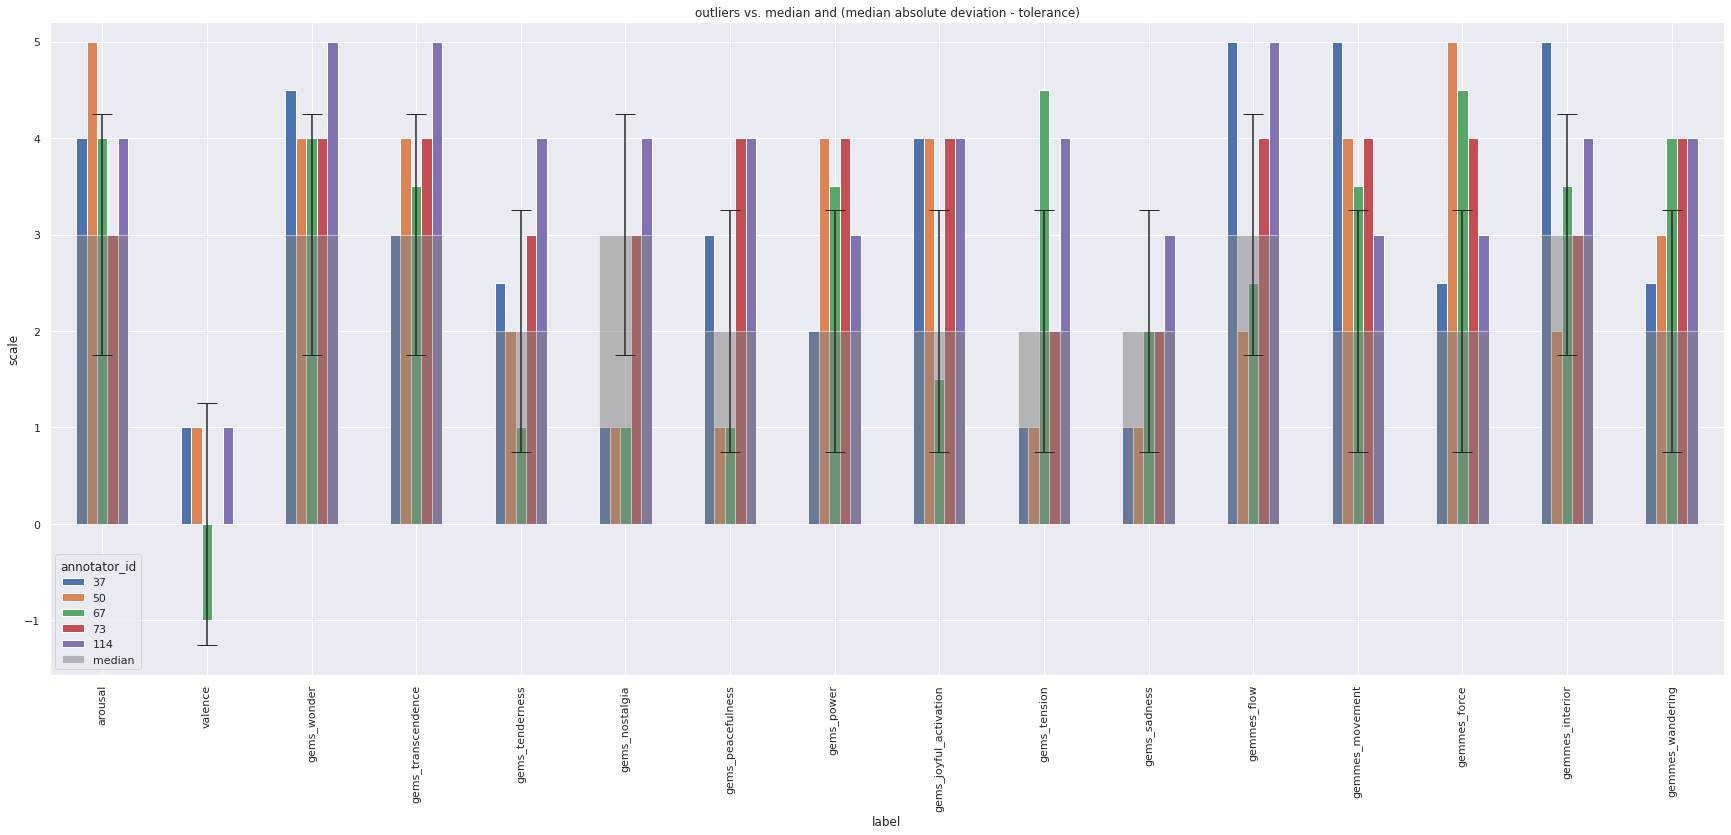

In [10]:
search_for_outliers(anot)